# Python code

## Imports

In [1]:
import os
import sys
import cv2
import time
import serial
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import image as mpimg
import requests

# Adding the src folder in the current directory as it contains the script for Thymio and local occupancy
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio
robot = Thymio.serial(port='COM3', refreshing_rate=0.1)

url = "http://192.168.0.180:8080/shot.jpg"

## Global variable

In [52]:
##### VISION

MAP_SIZE = 30
max_val = MAP_SIZE

## DO NOT CHANGE
NB_EXP_TURN = 2

EMPTY = 0
OCCUPIED = 1
EXPANDED = 2
INCUBATION = 3


##### ODOMETRY

## DO NOT CHANGE
CALIBRATION_TIME_ANGLE = 4.8
CALIBRATION_ANGLE = 180
CALIBRATION_TIME = 1.04
DISTANCE_CALLIBRATION = 3

FOURCHETTE = 5 # to uniform with the code
COTE_CARRE_MAP = 3



##### AVOIDANCE
## DO NOT CHANGE
SENSOR_0 = 0
SENSOR_1 = 1
SENSOR_2 = 2
SENSOR_3 = 3
SENSOR_4 = 4
SENSOR_5 = 5
SENSOR_6 = 6
ALL_FRONT_SENSOR = 5
PARTIALY_ALL_FRONT_SENSOR = 4
DIST_WHEELS = 9.4


PROXIMITY_THRESHOLD = 3800 #around 2cm
TIME_SLEEP_OBSTACLE = 0.1 #in seconds
DISTANCE_AVOIDANCE = 15 # to move away from the obstacle


#BOTH
MOTOR_SPEED = 80

### Vision

In [3]:
def create_empty_plot(max_val):
    """
    For plotting matters
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

In [4]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [5]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

In [6]:
def A_Star(start, goal, h, coords, occupancy_grid, max_val=MAP_SIZE):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    
    movements = _get_movements_8n()
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

In [7]:
def get_image():
    
#     filename = 'input_picture_2.png'
#     img = cv2.imread(filename, cv2.IMREAD_COLOR)

    vid_frames = requests.get(url)
    img_array = np.array(bytearray(vid_frames.content), dtype = np.uint8)
    img = cv2.imdecode(img_array, -1)

    #plot
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(7,7))
#     plt.imshow(img)
    img = img[125:1105,615:1595]
#     plt.figure(figsize=(7,7))
#     plt.imshow(img)
    
    return img

In [8]:
def expand_grid(occupancy_grid):
    
    nb_exp_turn = NB_EXP_TURN  
    
    for i in range(nb_exp_turn):
        occupancy_grid = expandation_turn(occupancy_grid)
        occupancy_grid = incubation_turn(occupancy_grid)
    
    return occupancy_grid

In [9]:
def expandation_turn(occupancy_grid):
    
    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==OCCUPIED or occupancy_grid[i,j]==EXPANDED):
                
                if(j==0):
                    L_col = j
                else:
                    L_col = j-1

                if(i==0):
                    T_line = i
                else:
                    T_line = i-1

                if(j==MAP_SIZE-1):
                    R_col = j
                else:
                    R_col = j+1

                if(i==MAP_SIZE-1):
                    B_line = i
                else:
                    B_line = i+1

                TL = [T_line, L_col]
                T = [T_line, j]
                TR = [T_line, R_col]
                ML = [i, L_col]
                MR = [i, R_col]
                BL = [B_line, L_col]
                B = [B_line, j]
                BR = [B_line, R_col]

                boxes_to_test = [TL, T, TR, ML, MR, BL, B, BR]
                
                for k in boxes_to_test:
                    if(occupancy_grid[k[0],k[1]]==EMPTY):
                        occupancy_grid[k[0],k[1]]=INCUBATION
                        
    return occupancy_grid

In [10]:
def incubation_turn(occupancy_grid):

    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==INCUBATION):
                occupancy_grid[i,j]=EXPANDED
                
    return occupancy_grid

In [11]:
def get_occupancy_grid(img):

    np.set_printoptions(threshold=sys.maxsize)

#     filename = 'input_picture_2.png'
#     img = cv2.imread(filename, cv2.IMREAD_COLOR)

    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(grayImage, (MAP_SIZE,MAP_SIZE), interpolation = cv2.INTER_AREA) 
#     plt.imshow(resized)
    height, width = resized.shape[:2] # Size of the map
    # fig, ax = create_empty_plot(width)

    ret,thresh1 = cv2.threshold(resized,90,255,cv2.THRESH_BINARY_INV)

    # plt.figure(figsize=(30,50))
    # plt.subplot(121),plt.imshow(img[:,:,::-1])
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(thresh1,cmap = 'gray')
    # plt.title('Threshold Image'), plt.xticks([]), plt.yticks([])
    #data = np.random.rand(max_val, max_val) * 20

    # cmap = colors.ListedColormap(['white', 'red'])
    occupancy_grid = thresh1.copy()
    occupancy_grid = occupancy_grid/255
    occupancy_grid = np.array(occupancy_grid, dtype=int)
    occupancy_grid = np.flip(occupancy_grid, 0)
    occupancy_grid = occupancy_grid.transpose()
    occupancy_grid = expand_grid(occupancy_grid)

    # ax.imshow(occupancy_grid, cmap=cmap)
    # plt.title("Map : free cells in white, occupied cells in red");

    # plt.show()
    occupancy_grid = np.array(occupancy_grid)
    
    return occupancy_grid

In [12]:
def get_data(img):
    original_height, original_width = img.shape[:2]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # resized = cv2.resize(img, (MAP_SIZE,MAP_SIZE), interpolation = cv2.INTER_AREA) 
    # plt.figure(figsize=(30,50))
    # plt.subplot(121),plt.imshow(img[:,:,::-1])
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(resized[:,:,::-1])
    # plt.title('Resized Image'), plt.xticks([]), plt.yticks([])

    # plt.show

    ##################### GOAL ##########################
#     template_goal = img[780:862,100:190,:]
    template_goal = cv2.imread('goal_template - Copy.png')
#     cv2.imwrite('goal_template.png', template_goal)
#     plt.figure()
#     plt.imshow(template_goal[:,:,::-1])
#     plt.show()

    #c, w, h  = template_goal.shape[::-1]
    res = cv2.matchTemplate(img,template_goal,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

#     plt.imshow(res)
#     plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    goal = min_loc
    x_goal=int(np.round(goal[0]*MAP_SIZE/original_width))
    y_goal=MAP_SIZE-int(np.round(goal[1]*MAP_SIZE/original_height)) #confirm height and width
    goal = (x_goal, y_goal)
    #print("Position of the goal [x, y] :", goal)

    ##################### ROBOT ##########################
#     template_back_point = img[593:615,610:635,:]
    template_back_point = cv2.imread('back_template - Copy.png')
#     cv2.imwrite('back_template.png', template_back_point)
#     plt.figure()
#     plt.imshow(template_back_point[:,:,::-1])
#     plt.show()

    res = cv2.matchTemplate(img,template_back_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

#     plt.imshow(res)
#     plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    back = [min_loc[0], min_loc[1]]
    #print("Position of the back point [x, y] :", back)
    back[1] = original_height-back[1]


#     template_front_point = img[625:650,605:630,:]
    template_front_point = cv2.imread('front_template - Copy.png')
#     cv2.imwrite('front_template.png', template_front_point)
#     plt.figure()
#     plt.imshow(template_front_point[:,:,::-1])
#     plt.show()

    res = cv2.matchTemplate(img,template_front_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

#     plt.imshow(res)
#     plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    front = [min_loc[0], min_loc[1]]
    #print("Position of the front point [x, y] :", front)
    front[1] = original_height-front[1]
    

    ############ Compute pos and orientation ############

    x=(back[0]+front[0])/2
    y=(back[1]+front[1])/2
    x=int(np.round(x*MAP_SIZE/original_width))
    y=int(np.round(y*MAP_SIZE/original_height))

    v = [front[0]-back[0], front[1]-back[1]]

    theta = math.atan2(v[1],v[0])

    robot_pose = [x, y, theta]
    start = (x,y)
    #print("Position of the robot [x, y, theta] :", robot_pose)
    
    return robot_pose, start, goal

In [13]:
def findroute(start, goal, occupancy_grid):
    x,y = np.mgrid[0:max_val:1, 0:max_val:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])

    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid)
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    
    return path, visitedNodes

In [30]:
def plot_map(visitedNodes, path, start, goal, occupancy_grid):
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    plt.show()
    return  fig_astar, ax_astar

In [31]:
def plot_step(path, start, goal, occupancy_grid, fig_astar, ax_astar):
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    plt.show()
    return

In [16]:
def set_course(target_list, idx, x, y, alpha):
    if (idx+3)<len(target_list[0]) :
        dy = target_list[1][idx+3] - y
        dx = target_list[0][idx+3] - x
    else:
        dy = target_list[1][idx] - y
        dx = target_list[0][idx] - x
    
    print("target : ", target_list[0][idx+3], target_list[1][idx+3])
    print("robot : ", x, y)
    
    alphatarg = math.atan2(dy,dx)
    dalpha = alphatarg - alpha
    
    while dalpha > math.pi :
        dalpha = dalpha - 2*math.pi
        
    while dalpha < -math.pi :
        dalpha = dalpha + 2*math.pi
    
    print(alpha, alphatarg, dalpha)
    
    if  dalpha > 0.2 :
        robot.set_var("motor.left.target", int(2**16)-int(MOTOR_SPEED/2)-5)
        robot.set_var("motor.right.target", int(MOTOR_SPEED/2)+5) 
    
    elif dalpha < -0.2:
        robot.set_var("motor.left.target", int(MOTOR_SPEED/2+5))
        robot.set_var("motor.right.target", int(2**16)-int(MOTOR_SPEED/2)-5)
    
    else:
        robot.set_var("motor.left.target", MOTOR_SPEED)
        robot.set_var("motor.right.target", MOTOR_SPEED) 
    return

### Odometry

In [17]:
def robot_turn(gamma, direction,alpha): #return alpha, direction, obstacle_seen (bool: 0->free)
    gamma = abs(gamma)
    time_turn = CALIBRATION_TIME_ANGLE*gamma/CALIBRATION_ANGLE
    obstacle_seen = 0
    
    if direction == "right":
        robot.set_var("motor.left.target", MOTOR_SPEED)
        robot.set_var("motor.right.target", int(int(2**16)-MOTOR_SPEED))
        t0 =time.time()
        while time.time()-t0 < time_turn :
            if (check_avoidance()) :
                obstacle_seen = 1
                avoid_obstacle()
                return alpha, direction, obstacle_seen
        
        alpha = angle_between_pi(alpha-math.radians(gamma))
        
    if direction == "left":
        robot.set_var("motor.left.target", int(int(2**16)-MOTOR_SPEED))
        robot.set_var("motor.right.target", MOTOR_SPEED)
        t0 =time.time()
        while time.time()-t0 < time_turn :
            if (check_avoidance()) :
                obstacle_seen = 1
                avoid_obstacle()
                return alpha, direction, obstacle_seen
        
        alpha = angle_between_pi(alpha+math.radians(gamma))
    
    direction = "forward"
    return alpha, direction, obstacle_seen

In [18]:
def angle_between_pi(angle): #return angle in [-pi,pi]
    if angle > math.pi :
        angle = angle - 2*math.pi
        return angle
    elif angle < -math.pi:
        angle = angle + 2*math.pi
        return angle
    else :
        return angle

In [19]:
def robot_move_forward(direction, distance,xr,xt,yr,yt): # distance is in cm , returns new xr, yr, obstacle_seen (bool:0->free)
    
    obstacle_seen = 0
    
    if direction == "forward" :
        time_forward = CALIBRATION_TIME*distance/DISTANCE_CALLIBRATION
        
        robot.set_var("motor.left.target", MOTOR_SPEED)
        robot.set_var("motor.right.target", MOTOR_SPEED)
        
        t0 =time.time()
        while time.time()-t0 < time_forward :
            if (check_avoidance()) :
                obstacle_seen = 1
                avoid_obstacle()
                return xr, yr, obstacle_seen

        xr=xt
        yr=yt
        
    return xr, yr, obstacle_seen

In [20]:
def robot_stop() :
    robot.set_var("motor.left.target", 0)
    robot.set_var("motor.right.target", 0)
    return

In [21]:
def robot_evaluation (xr,xt,yr,yt, alpha): #return gamma in degrees, direction, distance in cm
    
    alpha = math.degrees(alpha)
    xr=xr*COTE_CARRE_MAP
    xt=xt*COTE_CARRE_MAP
    yr=yr*COTE_CARRE_MAP
    yt=yt*COTE_CARRE_MAP
    
    if yt>yr and xt<xr :
        gamma = math.degrees(math.atan2(yt-yr,xr-xt))

        if alpha<=0 :
            gamma = gamma + 180+alpha

            if gamma < 180 :
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn left
                gamma = 360-gamma
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = 180 - gamma - alpha

            if gamma<0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)


    if yt<yr and xt<xr :  
        gamma = math.degrees(math.atan2(yr-yt,xr-xt))

        if alpha>=0 :
            gamma = gamma +180-alpha

            if gamma < 180 :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn right
                gamma = 360-gamma
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = 180 - gamma + alpha

            if gamma>0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)


    if yt<yr and xt>xr :  
        gamma = math.degrees(math.atan2(yr-yt,xt-xr))

        if alpha>=0 :
            gamma = gamma + alpha

            if gamma > 180 :
                #robot turn left
                gamma = 360-gamma
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = -alpha - gamma

            if gamma<0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        

    if yt>yr and xt>xr :
        gamma = math.degrees(math.atan2(yt-yr,xt-xr))

        if alpha<=0 :
            gamma = gamma - alpha

            if gamma > 180 :
                #robot turn right
                gamma = 360-gamma
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else:
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
        else :
            gamma = alpha - gamma

            if gamma>0:
                #robot turn right
                return abs(gamma), "right", math.sqrt((yt-yr)**2 + (xr-xt)**2)
            else :
                #robot turn left
                return abs(gamma), "left", math.sqrt((yt-yr)**2 + (xr-xt)**2)
    
    
    if yt==yr and xt>xr :
        gamma = 0
        distance = xt-xr
        
        if abs(alpha)< FOURCHETTE :
            #robot move forward
            return abs(gamma), "forward", distance
        elif alpha < -(FOURCHETTE/2) :
            #robot turn left
            return abs(gamma), "left", distance
        else :
            #robot turn right
            return abs(gamma), "right", distance
            
    if yt==yr and xt<xr :
        gamma = 180
        distance = xr-xt

        if alpha < 0 :
            gamma = gamma + alpha
            #robot turn right
            return abs(gamma), "right", distance
        else:
            gamma = gamma - alpha
            #robot turn left
            return abs(gamma), "left", distance
            
    
    if yt<yr and xt==xr :
        gamma = 90                           #=-90
        gamma = gamma+alpha
        distance = yr-yt

        if gamma < 0:
            #robot turn left
            return abs(gamma), "left", distance
        elif gamma > 180 :
            #robot turn left
            gamma= 360-gamma
            return abs(gamma), "left", distance
        else:
            #robot turn right
            return abs(gamma), "right", distance
            
            
    if yt>yr and xt==xr :
        gamma = 90
        gamma = gamma-alpha
        distance = yt-yr

        if gamma < 0 :
            #robot turn right
            return abs(gamma), "right", distance
        elif gamma > 180 :
            #robot turn right
            gamma= 360-gamma
            return abs(gamma), "right", distance
        else:
            #robot turn left
            return abs(gamma), "left", distance

In [22]:
def target_not_reach(xr,yr, target_list, id_target): # return bool yes/no
    
    xt = target_list[0][id_target]
    yt = target_list[1][id_target]
    
    if yt==yr and xt==xr :
        return False
    else:
        return True

### Obstacle avoidance

In [23]:
def obstacle_avoidance(obstacle_direction,sensor_measurment):
    if(np.shape(obstacle_direction)[0] == ALL_FRONT_SENSOR)or(np.shape(obstacle_direction)[0] == PARTIALY_ALL_FRONT_SENSOR):
        if(sensor_measurment[SENSOR_1]>sensor_measurment[SENSOR_3]):
            robot.set_var("motor.left.target", MOTOR_SPEED)
            robot.set_var("motor.right.target", 2**16-MOTOR_SPEED)
        else:
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
    else:
        if (np.any(np.equal(obstacle_direction,SENSOR_0)))or(np.any(np.equal(obstacle_direction,SENSOR_1))):
            robot.set_var("motor.left.target", MOTOR_SPEED)
            robot.set_var("motor.right.target", 2**16-MOTOR_SPEED)
        elif (np.any(np.equal(obstacle_direction,SENSOR_3)))or(np.any(np.equal(obstacle_direction,SENSOR_4))):
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
        elif (np.any(np.equal(obstacle_direction,SENSOR_2))):
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
    return

In [24]:
def check_avoidance() :
    sensor_measurment = robot["prox.horizontal"]
    if np.all(np.less(sensor_measurment, PROXIMITY_THRESHOLD)):
        return 0
    else:
        return 1

In [25]:
def avoid_obstacle () :
    sensor_measurment = robot["prox.horizontal"]
    obstacle_direction = np.nonzero(sensor_measurment)[0]
    while((np.any(np.greater(sensor_measurment, PROXIMITY_THRESHOLD)))and(np.all(np.not_equal(obstacle_direction, SENSOR_5)))and(np.all(np.not_equal(obstacle_direction, SENSOR_6)))):

        obstacle_avoidance(obstacle_direction,sensor_measurment)

        time.sleep(TIME_SLEEP_OBSTACLE)

        sensor_measurment = robot["prox.horizontal"]
        obstacle_direction = np.nonzero(sensor_measurment)[0]
    
    robot_move_forward("forward", DISTANCE_AVOIDANCE,0,0,0,0)
    robot_stop()
    
    return

### Main functions

In [50]:
def go_to_goal(target_list,occupancy_grid, fig_astar, ax_astar):

    img = get_image()
    (robot_pos, start, goal) = get_data(img)
    alpha = robot_pos[2] # in radian
    offset = 0

    for id_target in range (len(target_list[0])-1) :
        
        if id_target+offset < len(target_list[0]) :
            id_target = id_target+offset
        else :
            id_target = len(target_list[0])-1
        
        #print(target_not_reach(robot_pos[0],target_list[0][id_target],robot_pos[1],target_list[1][id_target]))
        while (target_not_reach(robot_pos[0],robot_pos[1],target_list, id_target)):
            gamma, direction, distance = robot_evaluation (robot_pos[0],target_list[0][id_target],robot_pos[1],target_list[1][id_target], alpha)

            #print('gamma: ',gamma,'direction: ',direction,'distance: ',distance)

            alpha, direction, obstacle_seen = robot_turn(gamma, direction, alpha)

            #print('alpha: ',math.degrees(alpha),'direction: ',direction)
            while(obstacle_seen):
                img = get_image()
                (robot_pos, start, goal) = get_data(img)
                alpha = robot_pos[2] # in radian

                obstacle_seen =0

                gamma, direction, distance = robot_evaluation (robot_pos[0],target_list[0][id_target],robot_pos[1],target_list[1][id_target], alpha)
                alpha, direction, obstacle_seen = robot_turn(gamma, direction, alpha)

            robot_pos[0], robot_pos[1], obstacle_seen = robot_move_forward(direction, distance,robot_pos[0],target_list[0][id_target],robot_pos[1],target_list[1][id_target])
            #print(obstacle_seen)
            if(obstacle_seen):
                img = get_image()
                (robot_pos, start, goal) = get_data(img)
                alpha = robot_pos[2] # in radian
                offset = offset + 10
        goal=(robot_pos[0],robot_pos[1])
        plot_step(path, start, goal, occupancy_grid,  fig_astar, ax_astar)
    robot_stop()
    

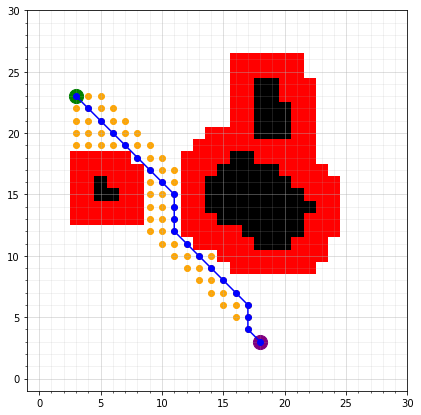

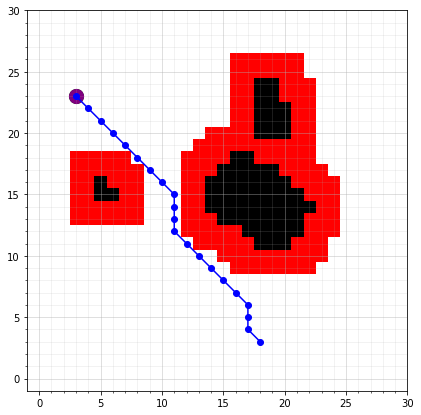

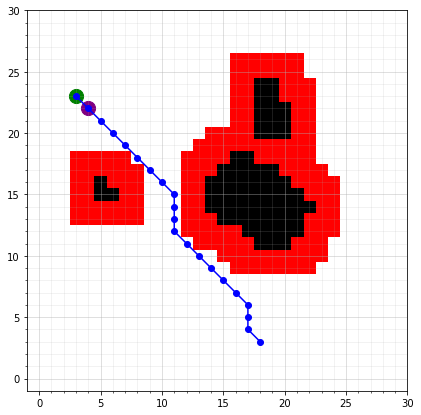

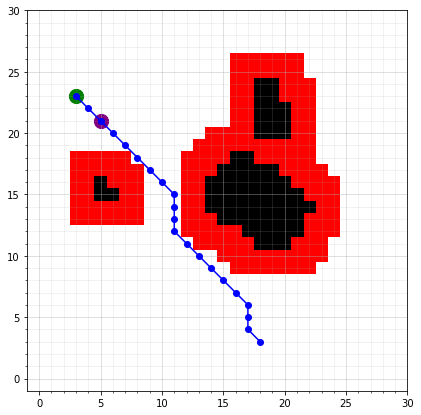

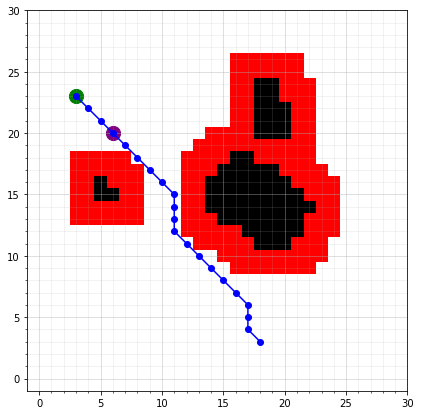

coucouF
coucouF
coucouF


KeyboardInterrupt: 

In [53]:
# Main:
# Get a picture of the map 
img = get_image()

# Get obstacle's postions
occupancy_grid = get_occupancy_grid(img)

# Get robot and goal's positions
(robot_pos, start, goal) = get_data(img)

# Find a route
path, visitedNodes = findroute(start, goal, occupancy_grid)

# Plot everything
(fig_astar, ax_astar) = plot_map(visitedNodes, path, start, goal, occupancy_grid)

go_to_goal(path, occupancy_grid,  fig_astar, ax_astar)

In [54]:
robot_stop()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\Users\roxan\Documents\Applications\Anaconda\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\roxan\Documents\Applications\Anaconda\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\roxan\Documents\EPFL_COURS\Basics of mobile robotics\Solutions_4\Solutions\src\Thymio.py", line 340, in do_refresh
    self.get_variables()
  File "C:\Users\roxan\Documents\EPFL_COURS\Basics of mobile robotics\Solutions_4\Solutions\src\Thymio.py", line 499, in get_variables
    self.send(msg)
  File "C:\Users\roxan\Documents\EPFL_COURS\Basics of mobile robotics\Solutions_4\Solutions\src\Thymio.py", line 456, in send
    self.io.write(msg.serialize())
  File "C:\Users\roxan\Documents\Applications\Anaconda\lib\site-packages\serial\serialwin32.py", line 315, in write
    raise SerialException("WriteFile failed ({!r})".format(ctypes.WinError()))
serial.seria